In [2]:
#READING CSV
import pandas as pd
from copy import deepcopy
import math

almacenes = pd.read_csv("https://raw.githubusercontent.com/billguerrerog/cc41_tf_201821590_20181B402_201811208_201823346_201823838/main/almacenes.csv")
alm = almacenes[['Coord X', 'Coord Y']]
nodeTypeALM = [1]*100
alm['NodeType'] = nodeTypeALM

puntos_entrega = pd.read_csv("https://raw.githubusercontent.com/billguerrerog/cc41_tf_201821590_20181B402_201811208_201823346_201823838/main/puntos_entrega.csv")
pe = puntos_entrega[['Coord X', 'Coord Y']]
nodeTypePE = [2]*5000
pe['NodeType'] = nodeTypePE

In [3]:
#Join both lists
newDF = pd.concat([alm, pe])

#List to use (nodeType) and list to compare (noType)
nodeTypeList = newDF[['Coord X', 'Coord Y', 'NodeType']].values.tolist()
noTypeList = newDF[['Coord X', 'Coord Y']].values.tolist()

In [4]:
#Sorting List by Y then by X
def orderList(list_):
    newL = sorted(list_, key=lambda y: y[1])
    newL.sort(key=lambda x: x[0])
    return deepcopy(newL)

newL = orderList(noTypeList)
newTypeList = orderList(nodeTypeList)

In [5]:
# Storage/DeliveryPoint Nodes to append
def popStuff(popList, times):
    to_return = []
    popList.reverse()
    for j in range(times):
        to_return.append(popList.pop())
    popList.reverse()
    return to_return

#Search X Coords Nodes (it's sorted already)
def searchX(tempList, tempNodeTypeList, x):
    returnList = []
    popped = []
    max = 0

    if len(tempList)==0 and len(tempNodeTypeList)==0:
        return returnList, popped
    for i in tempList: #Getting comparison list
        if i[0] == x:
            max += 1
            returnList.append(i)
        else:
            break
    
    popStuff(tempList, max)
    popped = []
    popped = popStuff(tempNodeTypeList, max)
    return returnList, popped

In [6]:
# Create graph
def graph(nodesList, newL_, newTypeList_):
    xList = [i for i in range(1000)]
    yList = [i for i in range(1000)]
    nodesCont = 0

    tempNoTypeList = deepcopy(newL_)
    tempTypeList = deepcopy(newTypeList_)

    for x in xList:
        smallList = [] #Comparison list
        popped = [] #To List
        if len(tempNoTypeList)>0 and len(tempTypeList)>0:
            smallList, popped = searchX(tempNoTypeList, tempTypeList, x)
        for y in yList:
            ady1 = nodesCont - 1000 #left then goes clockwise
            ady2 = nodesCont - 1
            ady3 = nodesCont + 1000
            ady4 = nodesCont + 1
            # Validations - not corners
            if x == 0: ady1 = -1
            if x == 999: ady3 = -1
            if y == 0: ady2 = -1
            if y == 999: ady4 = -1

            ady0 = [ady1, ady2, ady3, ady4]

            if len(popped) > 0 and len(smallList) > 0 and [x, y] in smallList:
                t = popped.pop(0)
                nodesList.append([t[0], t[1], t[2], ady0])
            else:
                nodesList.append([x, y, 0, ady0])
            
            nodesCont += 1

In [7]:
# Creating the new graph
nodes = []
graph(nodes, newL, newTypeList)

In [8]:
# Making a copy of resulting graph
nodes_copy = deepcopy(nodes)

In [9]:
#Methods to show graph
def popStuffAndDelete(popList, times):
    to_return = []
    popList.reverse()
    for j in range(times):
        popped = popList.pop()
        del popped[3]
        del popped[2]
        to_return.append(popped)
    popList.reverse()
    return to_return

def deleteStuff(nodesList):
    for i in nodesList:
        del i[3]
        del i[2]

def separateTypes(tempNodes, x):
    max = 0
    for i in tempNodes:
        if i[2] == x:
            max += 1
        else:
            popped = popStuffAndDelete(tempNodes, max)
            return popped

In [10]:
#Copies to show graph
new_nodes = sorted(nodes_copy, key=lambda y: y[2])
new_nodes_copy = deepcopy(new_nodes)

normal_nodes = separateTypes(new_nodes_copy, 0)
alm_nodes = separateTypes(new_nodes_copy, 1)
ent_nodes = new_nodes_copy
deleteStuff(ent_nodes)

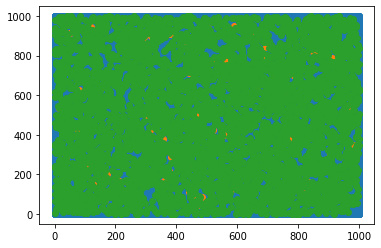

In [11]:
import matplotlib.pyplot as plt
import numpy as np

#Show graph
normal_np = np.array(normal_nodes)
alm_np = np.array(alm_nodes)
ent_np = np.array(ent_nodes)

plt.scatter(*zip(*normal_np))
plt.scatter(*zip(*alm_np))
plt.scatter(*zip(*ent_np))

cm = 1/2.54
plt.rcParams["figure.figsize"] = [60*cm, 30*cm]
plt.rcParams["figure.autolayout"] = True
plt.show()

In [12]:
# Making a copy of resulting graph
nodes_copy = deepcopy(nodes)

In [13]:
# BFS since all edges have the same weight (from a node)
def bfs(graph, s, size):
    visited = [False]*size
    parent = [None]*size
    queue = [s]
    visited[s] = True

    while queue:
        u = queue.pop(0)
        node = graph[u]
        for v in node[3]:
            if v >= 0:
                if not visited[v]:
                    visited[v] = True
                    parent[v] = u
                    queue.append(v)

    return parent

def find_route(all_routes, alm_node, ent_node):
    start_node = all_routes[ent_node] #returns parent
    #ir desde ent_node hasta alm_node con un while, hasta que encuentre el nodo que necesita
    #Las rutas se obtienen recorriendo las rutas generales de manera inversa
    route = []
    route.append(ent_node)

    if start_node == alm_node: #Comprueba si son nodos adyacentes
        route.append(alm_node)
        route.reverse()
        return route

    while start_node != alm_node: #Recorre los padres desde el punto de entrega hasta el almacén (inversamente)
        route.append(start_node)
        start_node = all_routes[start_node]

    route.append(alm_node)
    route.reverse()
    return route #returns 1 route

def get_coords(i):
    z = 1000
    x = i//z
    y = i % z
    return x, y

def get_node(x, y):
    return (x*1000) + y

def get_distance(alm_node, ent_node):
    alm_x, alm_y = get_coords(alm_node)
    ent_x, ent_y = get_coords(ent_node)
    return math.sqrt((ent_x - alm_x)**2 + (ent_y - alm_y)**2)

def find_nodes(graph, node_type, max):
    nodes = []
    cont_ent = 0
    size = len(graph)
    for i in range(size):
        if graph[i][2] == node_type:
            nodes.append(i)
            cont_ent += 1
        if cont_ent == max:
            return nodes #returns all nodes of that type

In [14]:
def find_shorter_route(graph, alm_node, size, ent_nodes_list, routes, shortest_routes):
    parent = bfs(graph, alm_node, size)

    for i in range(len(ent_nodes_list)): #ent_nodes
        route = []
        route.append(alm_node)
        route.append(ent_nodes_list[i])
        #check_route = find_route(parent, alm_node, ent_nodes_list[i])
        check_distance = get_distance(alm_node, ent_nodes_list[i]) #Closest to Storage Point
        if len(shortest_routes) < len(ent_nodes_list): # Empty list
            routes.append(route)
            shortest_routes.append(check_distance)
        else:
            #if len(check_route) < len(shortest_routes[i]): #Check if it's a shorter route
            if check_distance < shortest_routes[i]:
                routes[i] = route
                shortest_routes[i] = check_distance # Replace if so

def pop_asigned_delivery(ordered_list, storage_point):
    delivery_points = []
    for j in range(len(ordered_list)):
        if ordered_list[-1][0] == storage_point:
            aux = ordered_list.pop()
            delivery_points.append(aux[1])
            if len(ordered_list) == 0:
                return delivery_points
        else:
            return delivery_points

def shortest_routes(graph, size): #Only asking to every Storage node
    routes = []
    shortest_routes = []
    cont_alm = 0
    alm_nodes_list = find_nodes(graph, 1, 100) #alm = 1 / ent = 2
    ent_nodes_list = find_nodes(graph, 2, 5000) #alm = 1 / ent = 2

    for i in range(len(alm_nodes_list)):
        find_shorter_route(graph, alm_nodes_list[i], size, ent_nodes_list, routes, shortest_routes)

    #Order by Storage Point
    ordered_by_alm = sorted(routes, key=lambda a: a[0], reverse=True)
    by_alm = []
    for i in alm_nodes_list:
        asigned_delivery_points = []
        asigned_delivery_points = pop_asigned_delivery(ordered_by_alm, i)
        aux = []
        aux.append(i)
        aux.append(asigned_delivery_points)
        by_alm.append(aux)

    return by_alm #5k routes

In [15]:
#Takes 3 mins
asigned_delivery_points = shortest_routes(nodes_copy, len(nodes_copy))

In [16]:
for i in range(100):
    print(asigned_delivery_points[i])

[16535, [28485, 21503, 21469, 20478, 20476, 17545, 17468, 16471, 13534, 11475, 10544, 10485, 6498, 2590, 1461]]
[25978, [83998, 66974, 66963, 62987, 55999, 51975, 50955, 42956, 41999, 41988, 23993, 23974, 22962, 18987, 18974, 15996, 15969, 1978, 942]]
[29539, [30558, 25549, 23569, 20582, 20555, 15600, 14594, 4601]]
[31539, [124541, 124539, 112520, 109516, 108535, 104547, 104520, 103534, 95543, 94537, 93538, 81551, 81547, 81499, 80512, 79501, 74530, 74523, 74515, 72567, 70505, 69558, 64527, 60542, 59520, 58581, 55532, 54503, 52510, 51528, 48568, 45574, 45568, 45523, 42559, 40545, 38584, 38497, 36544, 35497, 33525]]
[38287, [91302, 91293, 83315, 82295, 78319, 78281, 76283, 71329, 69311, 62339, 57298, 57258, 54328, 51322, 47339, 42260, 37302, 37289, 34233, 31254, 29334, 28326, 28313, 23360, 21274, 21211, 19312, 18277, 17225, 16344, 16331, 16316, 16266, 15306, 10243, 8212, 4316, 4306, 4205, 3353, 3314, 1343, 1244, 1233]]
[50913, [75892, 70909, 69895, 69884, 61927, 61919, 61878, 51881, 4391

In [17]:
#Get single region
def get_region(alm, asigned_delivery):
    min_x, min_y = get_coords(alm) # Start
    max_x, max_y = get_coords(alm) # Start
    for i in asigned_delivery: #Getting min and max coords to create region
        delivery_x, delivery_y = get_coords(i) #Coords to compare
        if delivery_x < min_x: #Check min X
            min_x = delivery_x
        elif delivery_x > max_x: #Check max X
            max_x = delivery_x
        if delivery_y < min_y: #Check min Y
            min_y = delivery_y
        elif delivery_y > max_y: #Check max Y
            max_y = delivery_y

    min_max = [min_x, min_y, max_x, max_y]
    return min_max

# Get Regions
def all_regions(asigned_stuff):
    regions = []
    for i in asigned_stuff:
        aux = []
        region = get_region(i[0], i[1])
        aux.append(i[0])
        aux.append(region) #Region coords
        regions.append(aux)
    
    return regions

In [18]:
regions = all_regions(asigned_delivery_points)

In [19]:
import heapq as hq

def adjacencies(region): #Create region adjacencies
    xList = [i for i in range(region[0], region[2] + 1)]
    yList = [i for i in range(region[1], region[3] + 1)]

    nodes_region = {}

    for x in xList:
        for y in yList:
            nodes_region[get_node(x, y)] = []
    
    for node in nodes_region:
            ady1 = node - 1000 #left then goes clockwise
            ady2 = node - 1
            ady3 = node + 1000
            ady4 = node + 1

            ady0 = [ady1, ady2, ady3, ady4]
            for i in ady0:
                if i in nodes_region:
                    nodes_region[node].append(i)
    
    return nodes_region

def new_dijkstra(graph, start):
    visited = {}
    parent = {}
    cost = {}
    queue = [(start, 0)]
    for i in graph.keys():
        visited[i] = False
        parent[i] = None
        cost[i] = math.inf
    
    cost[start] = 0

    while queue:
        u, g_u = hq.heappop(queue)
        if not visited[u]:
            visited[u] = True
            for v in graph[u]:
                f = g_u + 1 #No cost
                if f < cost[v]:
                    cost[v] = f
                    parent[v] = u
                    hq.heappush(queue, (v, f))

    return parent

def all_regions(regions):
    routes = []
    regions_adj = []

    for i in range(len(regions)):
        alm, region = regions[i]
        nodes = adjacencies(region)

        route = new_dijkstra(nodes, alm)
        routes.append(route)
        
        regions_adj.append(nodes)

    return routes, regions_adj

In [20]:
routes, regions_adj = all_regions(regions)

In [21]:
for i in range(3):
    print(routes[i])
print(len(routes))

{1461: 1462, 1462: 1463, 1463: 1464, 1464: 1465, 1465: 1466, 1466: 1467, 1467: 1468, 1468: 1469, 1469: 1470, 1470: 1471, 1471: 1472, 1472: 1473, 1473: 1474, 1474: 1475, 1475: 1476, 1476: 1477, 1477: 1478, 1478: 1479, 1479: 1480, 1480: 1481, 1481: 1482, 1482: 1483, 1483: 1484, 1484: 1485, 1485: 1486, 1486: 1487, 1487: 1488, 1488: 1489, 1489: 1490, 1490: 1491, 1491: 1492, 1492: 1493, 1493: 1494, 1494: 1495, 1495: 1496, 1496: 1497, 1497: 1498, 1498: 1499, 1499: 1500, 1500: 1501, 1501: 1502, 1502: 1503, 1503: 1504, 1504: 1505, 1505: 1506, 1506: 1507, 1507: 1508, 1508: 1509, 1509: 1510, 1510: 1511, 1511: 1512, 1512: 1513, 1513: 1514, 1514: 1515, 1515: 1516, 1516: 1517, 1517: 1518, 1518: 1519, 1519: 1520, 1520: 1521, 1521: 1522, 1522: 1523, 1523: 1524, 1524: 1525, 1525: 1526, 1526: 1527, 1527: 1528, 1528: 1529, 1529: 1530, 1530: 1531, 1531: 1532, 1532: 1533, 1533: 1534, 1534: 1535, 1535: 2535, 1536: 1535, 1537: 1536, 1538: 1537, 1539: 1538, 1540: 1539, 1541: 1540, 1542: 1541, 1543: 1542, 154

In [22]:
for i in range(20):
    print(regions[i])

print(len(regions))

[16535, [1, 461, 28, 590]]
[25978, [0, 942, 83, 999]]
[29539, [4, 539, 30, 601]]
[31539, [31, 497, 124, 584]]
[38287, [1, 205, 91, 360]]
[50913, [1, 873, 75, 933]]
[55834, [1, 793, 93, 871]]
[76420, [4, 363, 85, 474]]
[77760, [5, 695, 183, 804]]
[79628, [3, 544, 134, 693]]
[98421, [85, 395, 116, 487]]
[100236, [48, 221, 153, 293]]
[103224, [6, 165, 143, 235]]
[103935, [70, 899, 111, 983]]
[113861, [97, 806, 134, 898]]
[119943, [99, 916, 212, 998]]
[122357, [75, 291, 212, 389]]
[127153, [0, 54, 163, 182]]
[138435, [105, 386, 212, 535]]
[140868, [124, 770, 230, 913]]
100


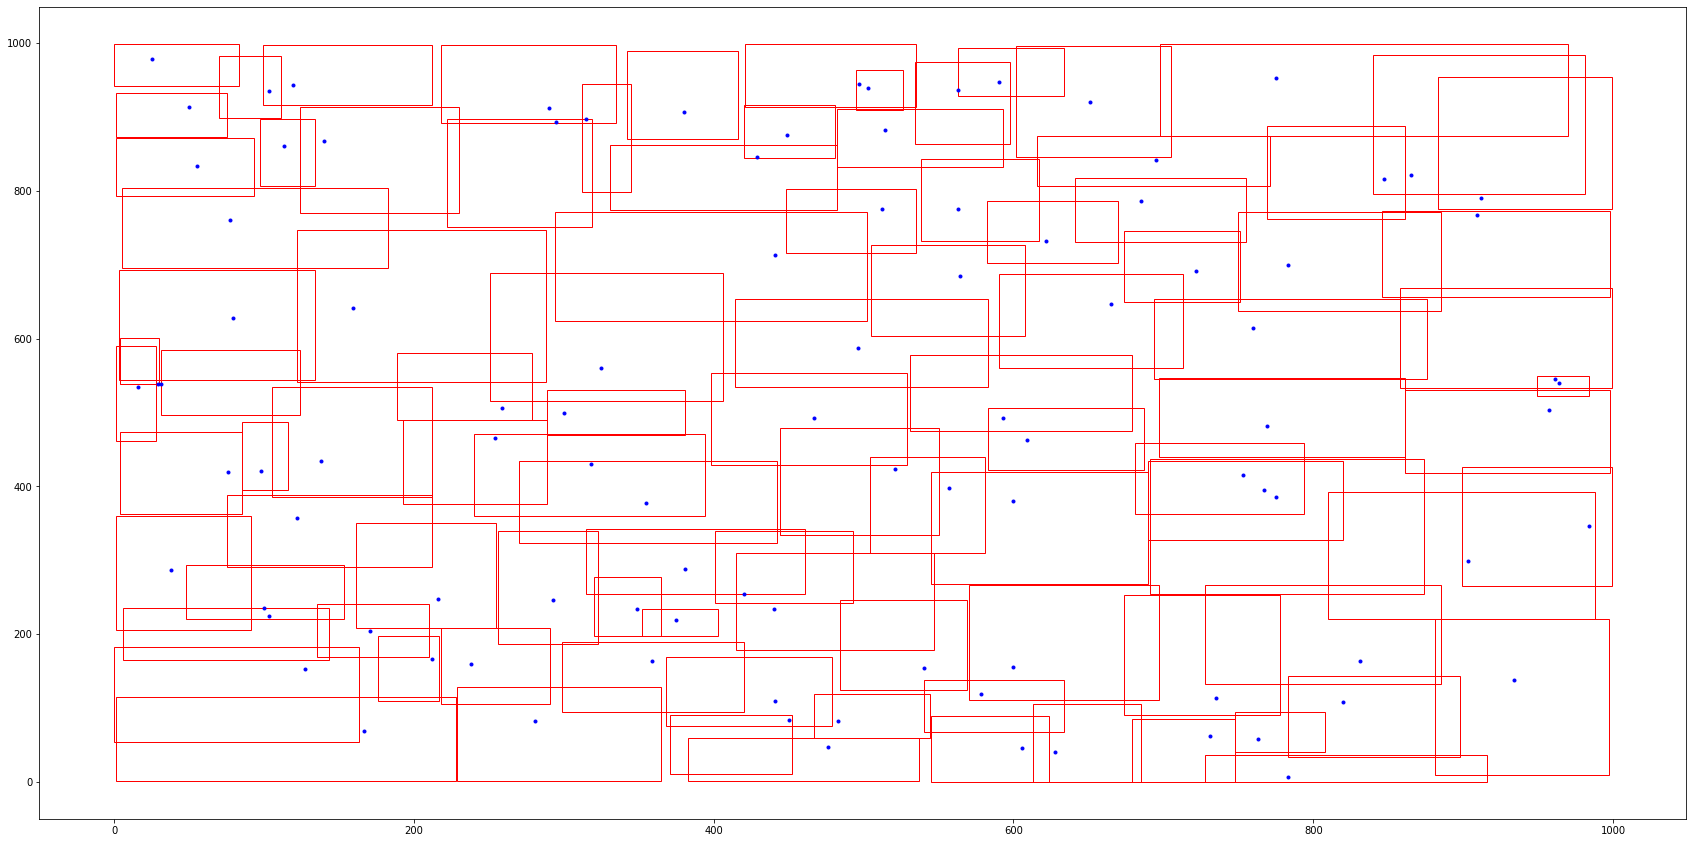

In [23]:
import matplotlib.patches as patches

fig, ax = plt.subplots()

for i in range(100):
    clr = 'red'
    min_x = regions[i][1][0]
    min_y = regions[i][1][1]
    max_x = regions[i][1][2]
    max_y = regions[i][1][3]
    rect = patches.Rectangle((min_x, min_y), max_x - min_x, max_y - min_y, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    cm = 1/2.54
    plt.rcParams["figure.figsize"] = [60*cm, 30*cm]
    alm_x, alm_y = get_coords(regions[i][0])
    plt.plot(alm_x, alm_y, '.', color='blue')
    plt.rcParams["figure.autolayout"] = True
    plt.plot

plt.show()

In [24]:
def get_my_region(all_regions, member_number):
    regions_size = int(len(all_regions)/5)
    min = member_number*regions_size
    max = (member_number + 1)*regions_size
    member_regions = []
    for i in range(min, max):
        member_regions.append(all_regions[i])

    return member_regions

### **ALGORITMO 1 - Bill Guerrero González - u201821590**

---

In [25]:
# ALGORITMO 1 - Bill Guerrero González - u201821590

# Not working yet
# def find_route_1(my_regions):
#     routes, regions_adj = all_regions(my_regions)


#     start_node = all_routes[ent_node] #returns parent
#     #ir desde ent_node hasta alm_node con un while, hasta que encuentre el nodo que necesita
#     #Las rutas se obtienen recorriendo las rutas generales de manera inversa
#     route = []
#     route.append(ent_node)

#     if start_node == alm_node: #Comprueba si son nodos adyacentes
#         route.append(alm_node)
#         route.reverse()
#         return route

#     while start_node != alm_node: #Recorre los padres desde el punto de entrega hasta el almacén (inversamente)
#         route.append(start_node)
#         start_node = all_routes[start_node]

#     route.append(alm_node)
#     route.reverse()
#     return route #returns 1 route

def algorithm_1(graph, start):
    visited = {}
    parent = {}
    for i in graph:
        visited[i] = False
        parent[i] = None
    
    visited[start] = True
    queue = [start]

    while queue:
        u = queue.pop(0)
        for v in graph[u]:
            if not visited[v]:
                visited[v] = True
                parent[v] = u
                queue.append(v)

    return parent

def my_routes_1(my_regions):
    routes = []

    for i in range(len(my_regions)):
        alm, region = my_regions[i]
        nodes = adjacencies(region)

        route = algorithm_1(nodes, alm)
        routes.append(route)

    return routes


my_regions_1 = get_my_region(regions, 0)
my_regions_routes = my_routes_1(my_regions_1)

for i in range(3):
    print(my_regions_routes[i])
print(len(my_regions_routes))

{1461: 1462, 1462: 1463, 1463: 1464, 1464: 1465, 1465: 1466, 1466: 1467, 1467: 1468, 1468: 1469, 1469: 1470, 1470: 1471, 1471: 1472, 1472: 1473, 1473: 1474, 1474: 1475, 1475: 1476, 1476: 1477, 1477: 1478, 1478: 1479, 1479: 1480, 1480: 1481, 1481: 1482, 1482: 1483, 1483: 1484, 1484: 1485, 1485: 1486, 1486: 1487, 1487: 1488, 1488: 1489, 1489: 1490, 1490: 1491, 1491: 1492, 1492: 1493, 1493: 1494, 1494: 1495, 1495: 1496, 1496: 1497, 1497: 1498, 1498: 1499, 1499: 1500, 1500: 1501, 1501: 1502, 1502: 1503, 1503: 1504, 1504: 1505, 1505: 1506, 1506: 1507, 1507: 1508, 1508: 1509, 1509: 1510, 1510: 1511, 1511: 1512, 1512: 1513, 1513: 1514, 1514: 1515, 1515: 1516, 1516: 1517, 1517: 1518, 1518: 1519, 1519: 1520, 1520: 1521, 1521: 1522, 1522: 1523, 1523: 1524, 1524: 1525, 1525: 1526, 1526: 1527, 1527: 1528, 1528: 1529, 1529: 1530, 1530: 1531, 1531: 1532, 1532: 1533, 1533: 1534, 1534: 1535, 1535: 2535, 1536: 1535, 1537: 1536, 1538: 1537, 1539: 1538, 1540: 1539, 1541: 1540, 1542: 1541, 1543: 1542, 154

### **ALGORITMO 2 - Josue Cuentas Jave - U20181B402**

---

In [26]:
#Second version
def algorithm_2(graph, start):
  visited = {}
  parent = {}

  for i in graph:
    visited[i] = False
    parent[i] = None

  stack = [start]

  while stack:
    u = stack.pop()
    if not visited[u]:
      visited[u] = True
      for v in graph[u]:
        if not visited[v]:
          parent[v] = u
          stack.append(v)

  return parent

def my_routes_2(my_regions):
    routes = []

    for i in range(len(my_regions)):
        alm, region = my_regions[i]
        nodes = adjacencies(region)

        route = algorithm_2(nodes, alm)
        routes.append(route)

    return routes

my_regions_2 = get_my_region(regions, 1)
my_regions_routes = my_routes_2(my_regions_2)

for i in range(3):
    print(my_regions_routes[i])
print(len(my_regions_routes))

{122541: 122542, 122542: 122543, 122543: 122544, 122544: 122545, 122545: 122546, 122546: 122547, 122547: 122548, 122548: 122549, 122549: 122550, 122550: 122551, 122551: 122552, 122552: 122553, 122553: 122554, 122554: 122555, 122555: 122556, 122556: 122557, 122557: 122558, 122558: 122559, 122559: 122560, 122560: 122561, 122561: 122562, 122562: 122563, 122563: 122564, 122564: 122565, 122565: 122566, 122566: 122567, 122567: 122568, 122568: 122569, 122569: 122570, 122570: 122571, 122571: 122572, 122572: 122573, 122573: 122574, 122574: 122575, 122575: 122576, 122576: 122577, 122577: 122578, 122578: 122579, 122579: 122580, 122580: 122581, 122581: 122582, 122582: 122583, 122583: 122584, 122584: 122585, 122585: 122586, 122586: 122587, 122587: 122588, 122588: 122589, 122589: 122590, 122590: 122591, 122591: 122592, 122592: 122593, 122593: 122594, 122594: 122595, 122595: 122596, 122596: 122597, 122597: 122598, 122598: 122599, 122599: 122600, 122600: 122601, 122601: 122602, 122602: 122603, 122603:

### **ALGORITMO 3 - José Ivan Tarazona Ildefonso - u201823346**

---

In [27]:
# ALGORITMO 3 - José Ivan Tarazona Ildefonso - u201823346

def algorithm_3(graph, start):
  visited = {}
  path = {}
  cost = {}
  for key in graph.keys():
    visited[key] = False
    path[key] = None
    cost[key] = math.inf

  cost[start] = 0
  queue = [(start, 0)]
  while queue:
    u, g_u = hq.heappop(queue)
    if not visited[u]:
      visited[u] = True        
      for v in graph[u]:
        f = g_u + 1
        if f < cost[v]:
          cost[v] = f
          path[v] = u
          hq.heappush(queue, (v, f))
  return path


def my_routes_3(my_regions):
    routes = []

    for i in range(len(my_regions)):
        alm, region = my_regions[i]
        nodes = adjacencies(region)

        route = algorithm_3(nodes, alm)
        routes.append(route)

    return routes


my_regions_1 = get_my_region(regions, 2)
my_regions_routes = my_routes_3(my_regions_1)

for i in range(3):
    print(my_regions_routes[i])
print(len(my_regions_routes))

{342870: 342871, 342871: 342872, 342872: 342873, 342873: 342874, 342874: 342875, 342875: 342876, 342876: 342877, 342877: 342878, 342878: 342879, 342879: 342880, 342880: 342881, 342881: 342882, 342882: 342883, 342883: 342884, 342884: 342885, 342885: 342886, 342886: 342887, 342887: 342888, 342888: 342889, 342889: 342890, 342890: 342891, 342891: 342892, 342892: 342893, 342893: 342894, 342894: 342895, 342895: 342896, 342896: 342897, 342897: 342898, 342898: 342899, 342899: 342900, 342900: 342901, 342901: 342902, 342902: 342903, 342903: 342904, 342904: 342905, 342905: 342906, 342906: 342907, 342907: 343907, 342908: 342907, 342909: 342908, 342910: 342909, 342911: 342910, 342912: 342911, 342913: 342912, 342914: 342913, 342915: 342914, 342916: 342915, 342917: 342916, 342918: 342917, 342919: 342918, 342920: 342919, 342921: 342920, 342922: 342921, 342923: 342922, 342924: 342923, 342925: 342924, 342926: 342925, 342927: 342926, 342928: 342927, 342929: 342928, 342930: 342929, 342931: 342930, 342932:

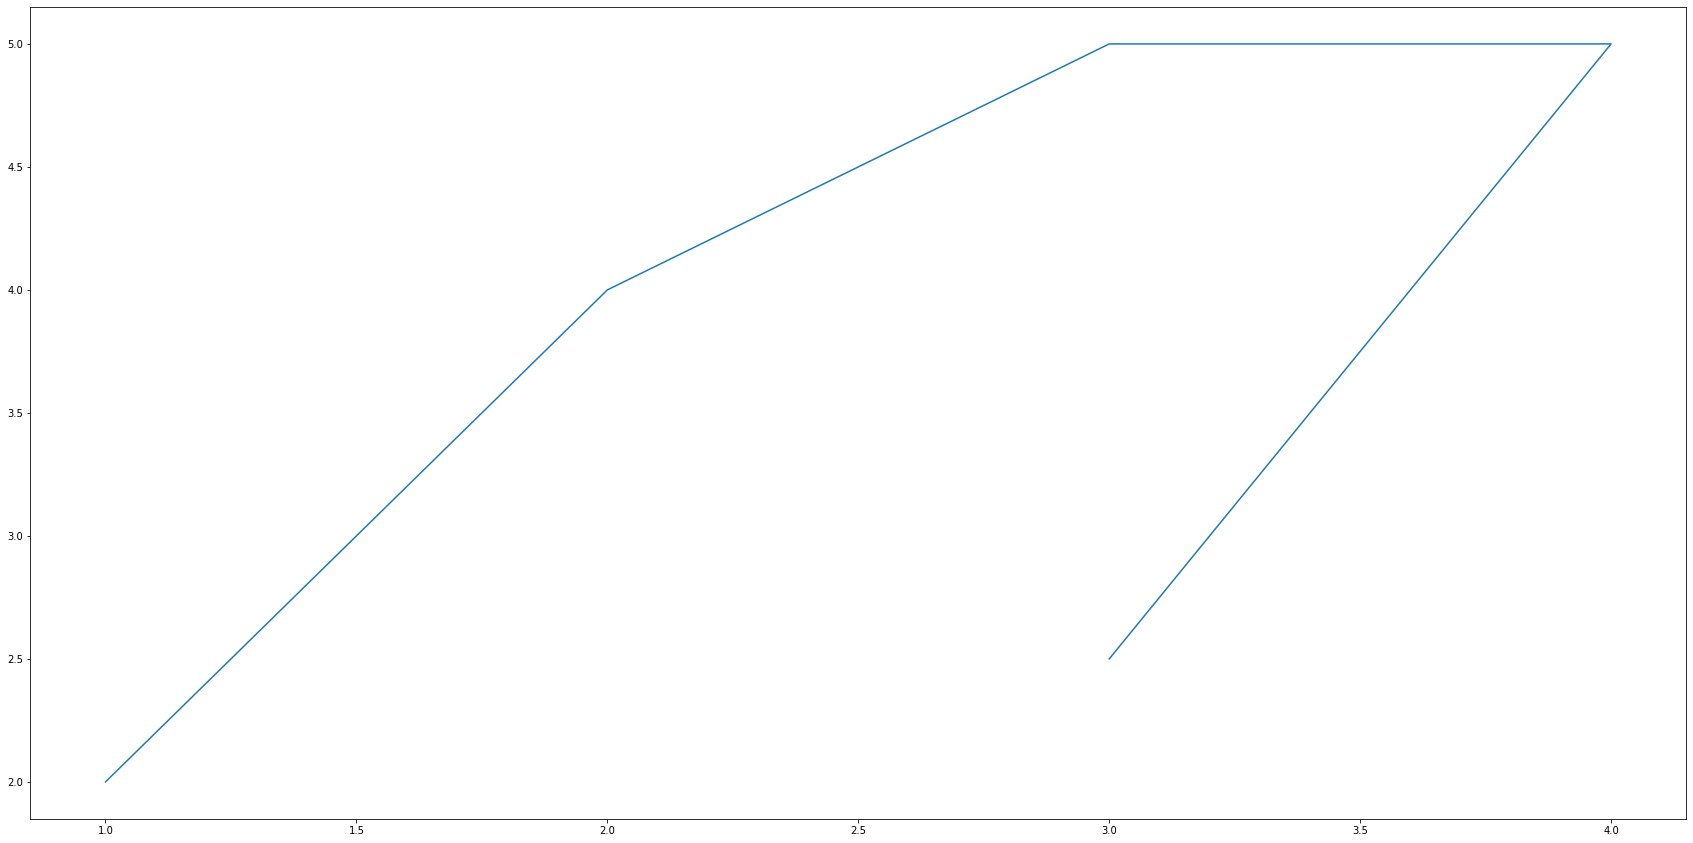

In [28]:
import numpy as np
import matplotlib.pyplot as plt

data = np.array([[1,2],[2,4],[3,5],[4,5], [3,2.5]])
#plt.plot(data[:, 0], data[:, 1])
plt.plot(*data.T)
plt.show()

### **ALGORITMO 4 - Sebastian Santiago Alfaro Mendoza - u201811208**

In [30]:
# ALGORITMO 4 - Sebastian Santiago Alfaro Mendoza - u201811208

def algorithm_4(G, s):
  n = len(G)
  visited = [False]*n
  path = [-1]*n
  cost = [math.inf]*n
  q = [(0, 0)]
  while q:
    _, u = hq.heappop(q)
    if not visited[u]:
      visited[u] = True
      for v, w in G[u]:
        if not visited[v] and w < cost[v]:
          cost[v] = w
          path[v] = u
          hq.heappush(q, (w, v))

  return path


def my_routes_4(my_regions):
    routes = []

    for i in range(len(my_regions)):
        alm, region = my_regions[i]
        nodes = adjacencies(region)

        route = algorithm_4(nodes, alm)
        routes.append(route)

    return routes

my_regions_4 = get_my_region(regions, 3)
my_regions_routes = my_routes_4(my_regions_4)

for i in range(3):
    print(my_regions_routes[i])
print(len(my_regions_routes))

{538732: 538733, 538733: 538734, 538734: 538735, 538735: 538736, 538736: 538737, 538737: 538738, 538738: 538739, 538739: 538740, 538740: 538741, 538741: 538742, 538742: 538743, 538743: 538744, 538744: 538745, 538745: 538746, 538746: 538747, 538747: 538748, 538748: 538749, 538749: 538750, 538750: 538751, 538751: 538752, 538752: 538753, 538753: 538754, 538754: 538755, 538755: 538756, 538756: 538757, 538757: 538758, 538758: 538759, 538759: 538760, 538760: 538761, 538761: 538762, 538762: 538763, 538763: 538764, 538764: 538765, 538765: 538766, 538766: 538767, 538767: 538768, 538768: 538769, 538769: 538770, 538770: 538771, 538771: 538772, 538772: 538773, 538773: 538774, 538774: 538775, 538775: 539775, 538776: 538775, 538777: 538776, 538778: 538777, 538779: 538778, 538780: 538779, 538781: 538780, 538782: 538781, 538783: 538782, 538784: 538783, 538785: 538784, 538786: 538785, 538787: 538786, 538788: 538787, 538789: 538788, 538790: 538789, 538791: 538790, 538792: 538791, 538793: 538792, 538794:

### **ALGORITMO 5 - José Adrian Pain Peralta - u201823838**

In [31]:
#Fibonnaci Heap
def fibonnaciheap(key, value):
    fibonnaciheap = {}
    fibonnaciheap[key] = value
    return fibonnaciheap

def insert(fibonnaciheap, key, value):
    fibonnaciheap[key] = value
    return fibonnaciheap

def minimum(fibonnaciheap):
    minimum = min(fibonnaciheap.keys())
    return minimum

def extract_min(fibonnaciheap):
    minimum = min(fibonnaciheap.keys())
    value = fibonnaciheap.pop(minimum)
    return value

def decrease_key(fibonnaciheap, key, value):
    fibonnaciheap[key] = value
    return fibonnaciheap

def delete(fibonnaciheap, key):
    fibonnaciheap.pop(key)
    return fibonnaciheap

def union(fibonnaciheap1, fibonnaciheap2):
    for key in fibonnaciheap2:
        fibonnaciheap1[key] = fibonnaciheap2[key]
    return fibonnaciheap1

def cut(fibonnaciheap, key):
    value = fibonnaciheap.pop(key)
    return value

def cascading_cut(fibonnaciheap, key):
    value = fibonnaciheap.pop(key)
    return value

def heappop(fibonnaciheap, key):
    value = fibonnaciheap.pop(key)
    return value

def heapush(fibonnaciheap, key, value):
    fibonnaciheap[key] = value
    return fibonnaciheap

In [32]:
def dijkstra(graph, source):
    fibonnaciheap = {}
    fibonnaciheap[source] = 0
    visited = []
    path = []
    path.append(source)
    visited.append(source)
    while len(visited) != len(graph):
        minimum = min(fibonnaciheap)
        value = extract_min(fibonnaciheap)
        visited.append(minimum)
        path.append(minimum)
        neighbors = graph[minimum]
        for neighbor in neighbors:
                fibonnaciheap[neighbor] = graph

    minimum = min(fibonnaciheap)
    value = extract_min(fibonnaciheap)
    visited.append(minimum)
    path.append(minimum)
    
    return path

def my_routes_4(my_regions):
    routes = []

    for i in range(len(my_regions)):
        alm, region = my_regions[i]
        nodes = adjacencies(region)

        route = dijkstra(nodes, alm)
        routes.append(route)

    return routes


my_regions_4 = get_my_region(regions, 4)
my_regions_routes = my_routes_4(my_regions_4)

for i in range(3):
    print(my_regions_routes[i])
print(len(my_regions_routes))

[760614, 760614, 759614, 758614, 757614, 756614, 755614, 754614, 753614, 752614, 751614, 750614, 749614, 748614, 747614, 746614, 745614, 744614, 743614, 742614, 741614, 740614, 739614, 738614, 737614, 736614, 735614, 734614, 733614, 732614, 731614, 730614, 729614, 728614, 727614, 726614, 725614, 724614, 723614, 722614, 721614, 720614, 719614, 718614, 717614, 716614, 715614, 714614, 713614, 712614, 711614, 710614, 709614, 708614, 707614, 706614, 705614, 704614, 703614, 702614, 701614, 700614, 699614, 698614, 697614, 696614, 695614, 694614, 694613, 694612, 694611, 694610, 694609, 694608, 694607, 694606, 694605, 694604, 694603, 694602, 694601, 694600, 694599, 694598, 694597, 694596, 694595, 694594, 694593, 694592, 694591, 694590, 694589, 694588, 694587, 694586, 694585, 694584, 694583, 694582, 694581, 694580, 694579, 694578, 694577, 694576, 694575, 694574, 694573, 694572, 694571, 694570, 694569, 694568, 694567, 694566, 694565, 694564, 694563, 694562, 694561, 694560, 694559, 694558, 694557,